## Setup

In [1]:
import random
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%load_ext line_profiler

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from utils import *
from q_learning import *
from deep_q_learning import *

In [2]:
# Configurations
save_stats = True
save_figs = True
train = False
load = not train

seed = 0

In [3]:
# Configuration paramaters for the whole setup
env = TictactoeEnv()

lr = 1e-4
epsilon_min = 0.1
epsilon_max = 0.8
num_episodes = 20000
test_freq = 250
num_avg = 4

# Folder for results
output_folder = os.path.join(os.getcwd(), 'results')
os.makedirs(output_folder, exist_ok=True)

## Learning from experts

### Question 11: Average reward and average loss during training

epsilon_exploration_Q11 = 0.1 : 	M_opt =  0.0 	M_rand =  0.954


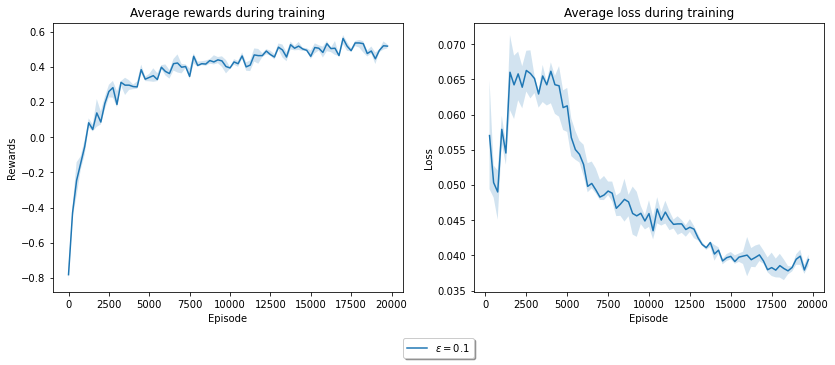

In [66]:
epsilon_exploration = 0.1
stats_dict_list = []
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
if train:
    for i in range(num_avg):
        print('************** RUN', i+1, 'OF', num_avg, '**************')
        stats_dict = {}
        start = time.time()
        model, stats = deep_q_learning(env, lr = lr, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, against_opt=True, verbose=True)
        print('Only training time: ', time.time() - start)
        M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
        M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
        stats_dict_list.append(stats_dict)
        print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')
    if save_stats:
        fname = output_folder + '/dqn_stats_dict_q11.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
if load:
    fname = output_folder + '/dqn_stats_dict_q11.pkl'
    with open(fname, 'rb') as handle:
            stats_dict_list = pickle.load(handle)

plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q11', '\epsilon', save=save_figs, keys = ['rewards', 'loss'], perc=True)
output_folder = os.path.join(os.getcwd(), 'results')

In [ ]:
plot_stats([stats_dict_list[-1]], [epsilon_exploration], 'epsilon_exploration_Q11', '\epsilon', save=save_figs)

### Question 12: no replay buffer and batch_size = 1

epsilon_exploration_Q12 = 0.1 : 	M_opt =  -0.098 	M_rand =  0.825


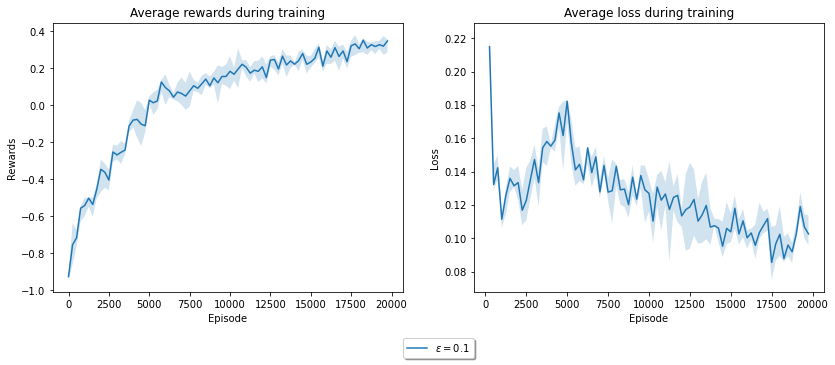

In [64]:
epsilon_exploration = 0.1
stats_dict_list = []
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
if train:
    for i in range(num_avg):
        print('************** RUN', i+1, 'OF', num_avg, '**************')
        stats_dict = {}
        start = time.time()
        model, stats = deep_q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, against_opt=True, batch_size=1, max_memory_length=1)
        M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
        M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
        stats_dict_list.append(stats_dict)
        print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')
    if save_stats:
        fname = output_folder + '/dqn_stats_dict_q12.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

if load:
    fname = output_folder + '/dqn_stats_dict_q12.pkl'
    with open(fname, 'rb') as handle:
            stats_dict_list = pickle.load(handle)

plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q12', '\epsilon', save=save_figs, keys = ['rewards', 'loss'], perc=True)

### Question 13: Decreasing exploration for different values of $n^{*}$

In [4]:
vec_n_star = np.hstack((np.array([1, 100, 1000]), np.round(np.logspace(np.log10(5000), np.log10(40000), 7))))
num_splits = 5
chunks_list = np.array_split(vec_n_star, num_splits)
print(chunks_list)

[array([  1., 100.]), array([1000., 5000.]), array([ 7071., 10000.]), array([14142., 20000.]), array([28284., 40000.])]


In [5]:
dqn_params_list = []
for (idx, chunk) in enumerate(chunks_list):
    dqn_params_list.append([])
    for n_star in chunk:
        params = {'env': env,
                  'num_episodes': num_episodes,
                  'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
                  'test_freq': test_freq,
                  'against_opt': True}
        dqn_params_list[idx].append(params)

In [6]:
chunk_num = 0
if train:
    var_name = 'dqn_n_star_experts_' + str(chunk_num)
    chunk = chunks_list[chunk_num]
    stats_dict_nstar = train_avg(var_name, chunk, dqn_params_list[chunk_num], dqn = True, num_avg=num_avg, save_stats=save_stats)

In [7]:
# Merge
stats_dicts = {}
if save_stats:
    stats_dict_nstar_list = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    for i in range(len(chunks_list)):
        fname = output_folder + '/stats_dict_dqn_n_star_experts_' + str(i) + '_list.pkl'
        with open(fname, 'rb') as handle:
            stats_dicts.update({i: pickle.load(handle)})
    for i in range(num_avg):
        to_append = {}
        for key in stats_dicts.keys():
            to_append.update(stats_dicts[key][i])
        stats_dict_nstar_list.append(to_append)
    fname = output_folder + '/dqn_stats_dict_nstar_experts_list.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ivanb\\Documents\\GitHub\\ANN_Project\\code\\results/stats_dict_dqn_n_star_experts_3_list.pkl'

dqn_n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.9339999999999999
dqn_n_star = 10000.0 : 	M_opt =  0.0 	M_rand =  0.952
dqn_n_star = 20000.0 : 	M_opt =  0.0 	M_rand =  0.9339999999999999
dqn_n_star = 40000.0 : 	M_opt =  0.0 	M_rand =  0.945


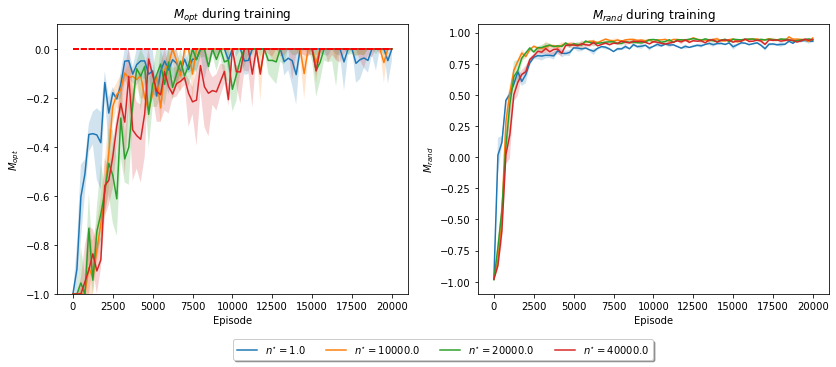

In [8]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/dqn_stats_dict_nstar_experts_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

plot_n_star = [1., 10000., 20000., 40000.]
plot_stats(stats_dict_nstar_list, plot_n_star, 'dqn_n_star', "n^{\star}", save=save_figs, perc=True, keys=['test_Mopt', 'test_Mrand'])

dqn_n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.9339999999999999
dqn_n_star = 100.0 : 	M_opt =  0.0 	M_rand =  0.929
dqn_n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.942
dqn_n_star = 5000.0 : 	M_opt =  0.0 	M_rand =  0.9410000000000001
dqn_n_star = 7071.0 : 	M_opt =  0.0 	M_rand =  0.938
dqn_n_star = 10000.0 : 	M_opt =  0.0 	M_rand =  0.952
dqn_n_star = 14142.0 : 	M_opt =  -0.096 	M_rand =  0.948
dqn_n_star = 20000.0 : 	M_opt =  0.0 	M_rand =  0.9339999999999999
dqn_n_star = 28284.0 : 	M_opt =  0.0 	M_rand =  0.955
dqn_n_star = 40000.0 : 	M_opt =  0.0 	M_rand =  0.945


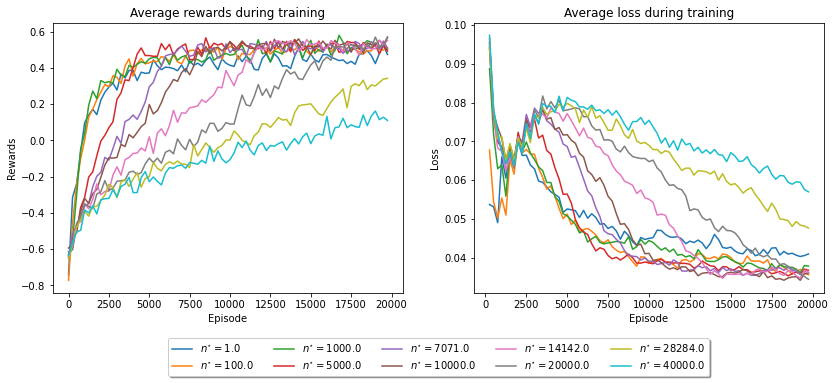

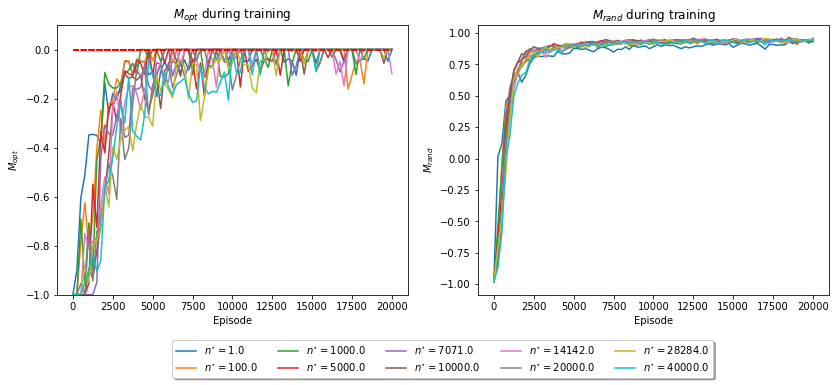

In [9]:
plot_stats(stats_dict_nstar_list, vec_n_star, 'dqn_n_star', "n^{\star}", save=False, decaying_exploration=False)

### Question 14: Different values of $\epsilon_{\text{opt}}$

In [10]:
best_n_star = 20000
M = 11
vec_epsilon_opt = np.round(np.linspace(0, 1, M), decimals=2)
deep_q_learning_params_list = []
var_name = "epsilon_opt_deep"
for eps in vec_epsilon_opt:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, best_n_star),
              'epsilon_opt': eps,
              'test_freq': test_freq,
              'against_opt': True}
    deep_q_learning_params_list.append(params)

In [11]:
if train:
    stats_dict_epsilon_opt_list_deep = train_avg(var_name, vec_epsilon_opt, deep_q_learning_params_list, dqn = True,
                                                      num_avg=num_avg, save_stats=save_stats)

In [12]:
# Merge
stats_dicts = {}
if save_stats:
    stats_dict_eps_opt_list = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    for i in range(len(chunks_list)):
        fname = output_folder + '/stats_dict_dqn_epsilon_opt_experts_' + str(i) + '_list.pkl'
        with open(fname, 'rb') as handle:
            stats_dicts.update({i: pickle.load(handle)})
    for i in range(num_avg):
        to_append = {}
        for key in stats_dicts.keys():
            to_append.update(stats_dicts[key][i])
        stats_dict_eps_opt_list.append(to_append)
    fname = output_folder + '/stats_dict_dqn_epsilon_opt_experts_list.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_eps_opt_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

dqn_epsilon_opt_experts = 0.0 : 	M_opt =  0.0 	M_rand =  -0.326
dqn_epsilon_opt_experts = 0.2 : 	M_opt =  0.0 	M_rand =  0.92
dqn_epsilon_opt_experts = 0.5 : 	M_opt =  0.0 	M_rand =  0.9390000000000001
dqn_epsilon_opt_experts = 0.7 : 	M_opt =  -0.098 	M_rand =  0.951
dqn_epsilon_opt_experts = 1.0 : 	M_opt =  -0.227 	M_rand =  0.915


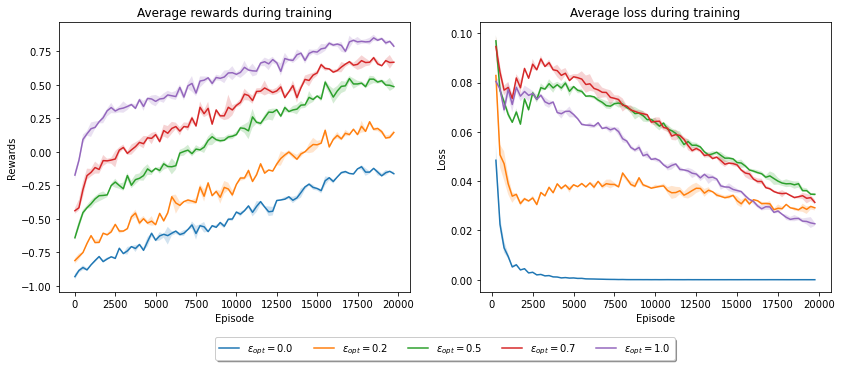

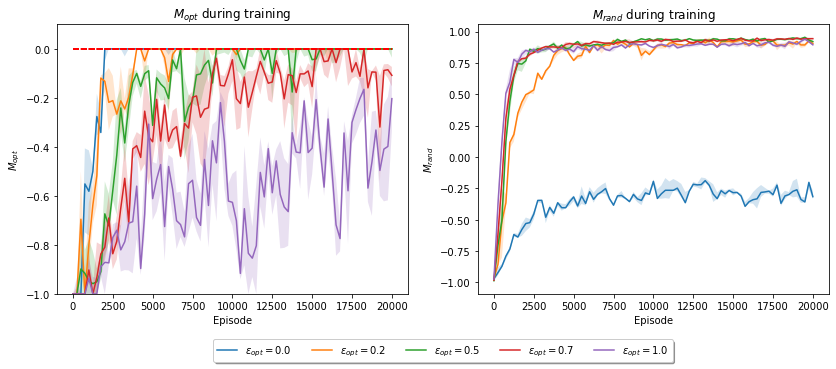

In [13]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_dqn_epsilon_opt_experts_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_opt_list = pickle.load(handle)

plot_epsilon_opt = [0.0, 0.2, 0.5, 0.7, 1.0]
plot_stats(stats_dict_eps_opt_list, plot_epsilon_opt, 'dqn_epsilon_opt_experts', "\epsilon_{opt}", save=save_figs, perc=True)

dqn_epsilon_opt_experts = 0.0 : 	M_opt =  0.0 	M_rand =  -0.326
dqn_epsilon_opt_experts = 0.1 : 	M_opt =  0.0 	M_rand =  0.91
dqn_epsilon_opt_experts = 0.2 : 	M_opt =  0.0 	M_rand =  0.92
dqn_epsilon_opt_experts = 0.3 : 	M_opt =  0.0 	M_rand =  0.9299999999999999
dqn_epsilon_opt_experts = 0.4 : 	M_opt =  0.0 	M_rand =  0.951
dqn_epsilon_opt_experts = 0.5 : 	M_opt =  0.0 	M_rand =  0.9390000000000001
dqn_epsilon_opt_experts = 0.6 : 	M_opt =  0.0 	M_rand =  0.938
dqn_epsilon_opt_experts = 0.7 : 	M_opt =  -0.098 	M_rand =  0.951
dqn_epsilon_opt_experts = 0.8 : 	M_opt =  -0.17300000000000001 	M_rand =  0.937
dqn_epsilon_opt_experts = 0.9 : 	M_opt =  -0.10300000000000001 	M_rand =  0.927
dqn_epsilon_opt_experts = 1.0 : 	M_opt =  -0.227 	M_rand =  0.915


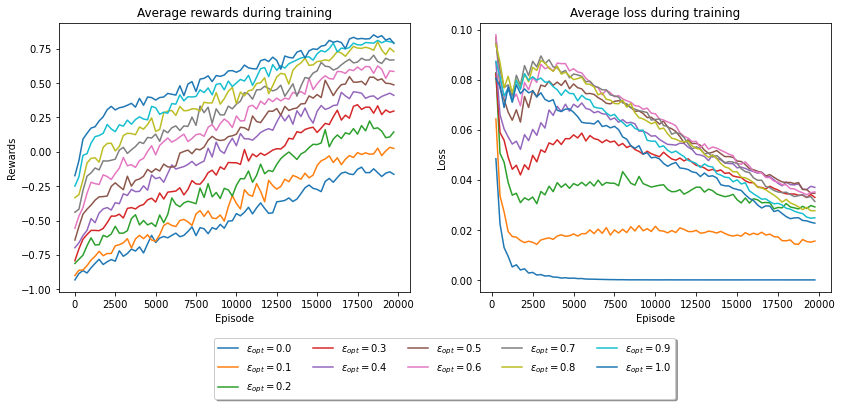

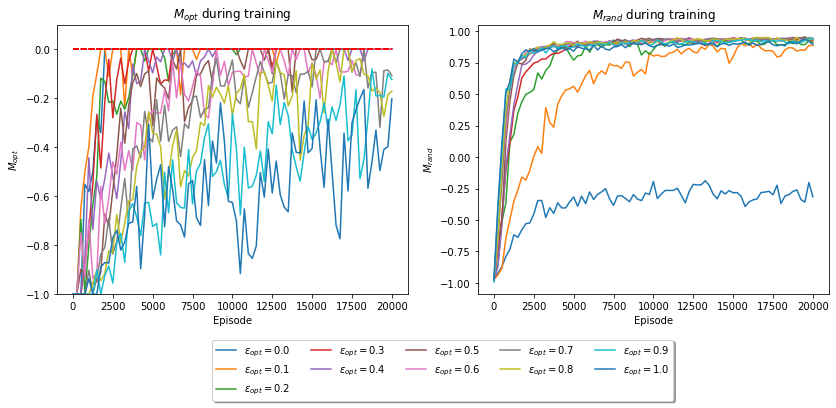

In [14]:
plot_stats(stats_dict_eps_opt_list, vec_epsilon_opt, 'dqn_epsilon_opt_experts', "\epsilon_{opt}", save=False)

### Question 15: Best values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [32]:
# TODO
num_avg = 4

## Learning by self-practice

************** RUN 1 OF 4 **************


100%|██████████| 20000/20000 [29:49<00:00, 11.17it/s]  


M_opt = 0.0
M_rand = 0.942
RUN 1 took 1802.5 seconds
************** RUN 2 OF 4 **************


100%|██████████| 20000/20000 [29:49<00:00, 11.18it/s]  


M_opt = -0.134
M_rand = 0.972
RUN 2 took 1801.8 seconds
************** RUN 3 OF 4 **************


100%|██████████| 20000/20000 [29:20<00:00, 11.36it/s]  


M_opt = -0.106
M_rand = 0.954
RUN 3 took 1771.4 seconds
************** RUN 4 OF 4 **************


100%|██████████| 20000/20000 [29:18<00:00, 11.38it/s]  


M_opt = 0.0
M_rand = 0.95
RUN 4 took 1769.9 seconds
self_practice_test = 0.5 : 	M_opt =  -0.053 	M_rand =  0.952


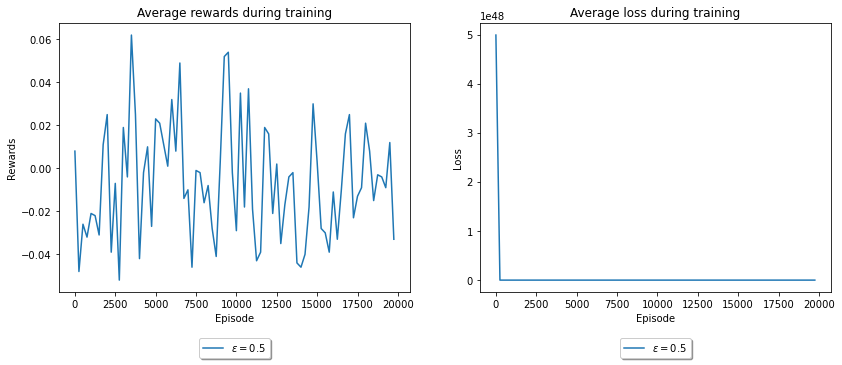

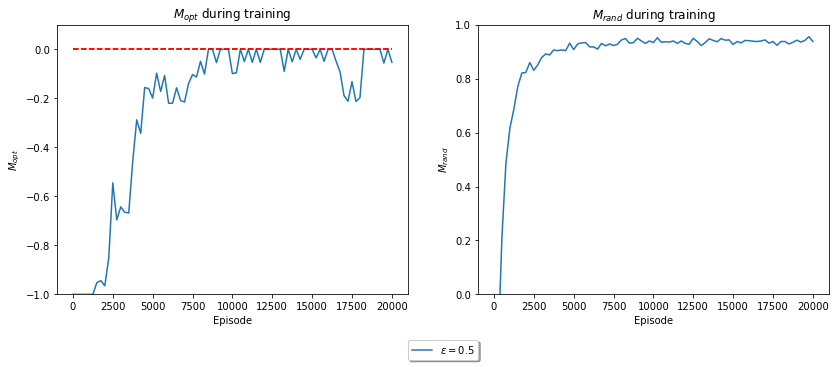

FileNotFoundError: [Errno 2] No such file or directory: 'C:/results/dqn_stats_dict_q15.pkl'

In [52]:
epsilon_exploration = 0.5
stats_dict_list = []
for i in range(num_avg):
    print('************** RUN', i+1, 'OF', num_avg, '**************')
    stats_dict = {}
    start = time.time()
    model, stats = deep_q_learning(env, lr = 5e-5, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, test_freq=test_freq, self_practice=True)
    M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
    M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
    stats_dict_list.append(stats_dict)
    print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')

plot_stats(stats_dict_list, [epsilon_exploration], 'self_practice_test', '\epsilon', save=save_figs)
output_folder = os.path.join(os.getcwd(), '/results')
fname = output_folder + '/dqn_stats_dict_q15.pkl'
with open(fname, 'wb') as handle:
    pickle.dump(stats_dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
output_folder = os.path.join(os.getcwd(), 'results')
fname = output_folder + '/dqn_stats_dict_q15.pkl'
with open(fname, 'wb') as handle:
    pickle.dump(stats_dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Question 16: Different values of the exploration rate $\epsilon$

In [15]:
M = 10
vec_eps = np.linspace(0, 0.9, M)
num_splits = 5
chunks_list = np.array_split(vec_eps, num_splits)
print(chunks_list)
dqn_params_list = []
for (idx, chunk) in enumerate(chunks_list):
    dqn_params_list.append([])
    for eps in chunk:
        params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration': eps,
              'verbose': True,
              'test_freq': test_freq,
              'self_practice': True,
              'lr': lr}
        dqn_params_list[idx].append(params)

[array([0. , 0.1]), array([0.2, 0.3]), array([0.4, 0.5]), array([0.6, 0.7]), array([0.8, 0.9])]


In [16]:
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
chunk_num = 0
if train:
    var_name = 'dqn_eps_self_practice_' + str(chunk_num)
    chunk = chunks_list[chunk_num]
    stats_dict_epsilon_self_list_deep = train_avg(var_name, chunk, dqn_params_list[chunk_num], dqn = True,
                                                        num_avg=num_avg, save_stats=save_stats)

In [17]:
# Merge
stats_dicts = {}
if save_stats:
    stats_dict_epsilon_self_list_deep = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    for i in range(len(chunks_list)):
        fname = output_folder + '/stats_dict_dqn_eps_self_practice_' + str(i) + '_list.pkl'
        with open(fname, 'rb') as handle:
            stats_dicts.update({i: pickle.load(handle)})
    for i in range(num_avg):
        to_append = {}
        for key in stats_dicts.keys():
            to_append.update(stats_dicts[key][i])
        stats_dict_epsilon_self_list_deep.append(to_append)
    fname = output_folder + '/stats_dict_dqn_eps_self_practice.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_epsilon_self_list_deep, handle, protocol=pickle.HIGHEST_PROTOCOL)

epsilon_dqn_self = 0.0 : 	M_opt =  -1.0 	M_rand =  0.14
epsilon_dqn_self = 0.2 : 	M_opt =  0.0 	M_rand =  0.935
epsilon_dqn_self = 0.5 : 	M_opt =  0.0 	M_rand =  0.93
epsilon_dqn_self = 0.8 : 	M_opt =  -0.45099999999999996 	M_rand =  0.922


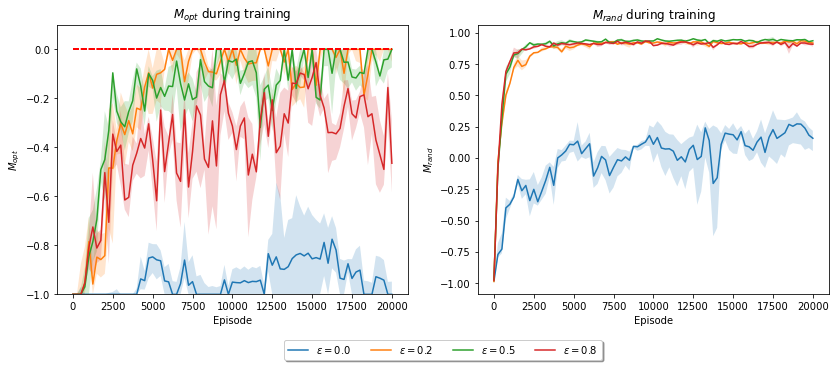

In [29]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_dqn_eps_self_practice.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_epsilon_self_list_deep = pickle.load(handle)

plot_eps = [vec_eps[i] for i in [0, 2, 5, 8]]
plot_stats(stats_dict_epsilon_self_list_deep, plot_eps, 'epsilon_dqn_self', "\epsilon", save=save_figs, decaying_exploration=False, perc=True, keys=['test_Mopt', 'test_Mrand'])

epsilon = 0.0 : 	M_opt =  -1.0 	M_rand =  0.14
epsilon = 0.1 : 	M_opt =  -0.14900000000000002 	M_rand =  0.914
epsilon = 0.2 : 	M_opt =  0.0 	M_rand =  0.935
epsilon = 0.30000000000000004 : 	M_opt =  0.0 	M_rand =  0.936
epsilon = 0.4 : 	M_opt =  -0.053 	M_rand =  0.9390000000000001
epsilon = 0.5 : 	M_opt =  0.0 	M_rand =  0.93
epsilon = 0.6000000000000001 : 	M_opt =  -0.049 	M_rand =  0.921
epsilon = 0.7000000000000001 : 	M_opt =  -0.053 	M_rand =  0.928
epsilon = 0.8 : 	M_opt =  -0.45099999999999996 	M_rand =  0.922
epsilon = 0.9 : 	M_opt =  -0.567 	M_rand =  0.865


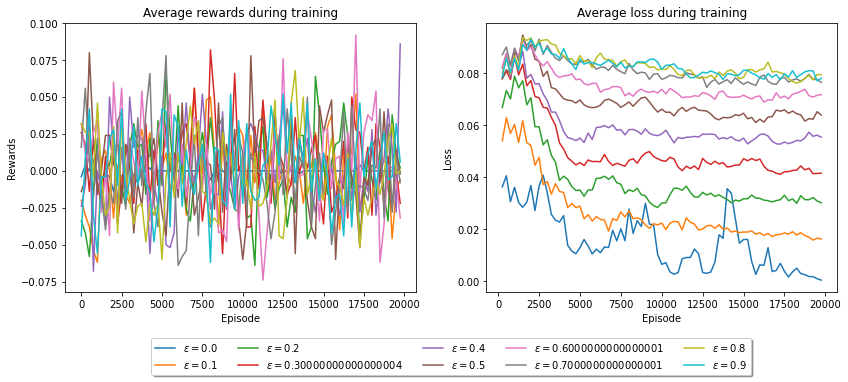

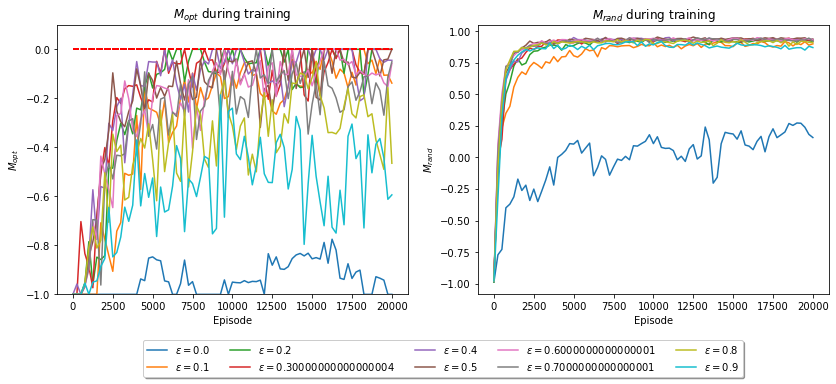

In [30]:
plot_stats(stats_dict_epsilon_self_list_deep, vec_eps, 'epsilon', "\epsilon", save=False, decaying_exploration=False)

### Question 17: Decreasing exploration for different values of $n^*$

In [21]:
vec_n_star = np.hstack((np.array([1, 100, 1000]), np.round(np.logspace(np.log10(5000), np.log10(40000), 7))))
num_splits = 5
chunks_list = np.array_split(vec_n_star, num_splits)
print(chunks_list)

dqn_params_list = []
for (idx, chunk) in enumerate(chunks_list):
    dqn_params_list.append([])
    for n_star in chunk:
        params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'verbose': True,
              'test_freq': test_freq,
              'self_practice': True,
              'lr': lr}
        dqn_params_list[idx].append(params)

[array([  1., 100.]), array([1000., 5000.]), array([ 7071., 10000.]), array([14142., 20000.]), array([28284., 40000.])]


In [22]:
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
chunk_num = 0
if train:
    var_name = 'dqn_n_star_self_practice_' + str(chunk_num)
    stats_dict_nstar_self_list_deep = train_avg(var_name,chunks_list[chunk_num], dqn_params_list[chunk_num], dqn = True,
                                                     num_avg=num_avg, save_stats=True)

In [23]:
# Merge
stats_dicts = {}
if save_stats:
    stats_dict_n_star_self_list_deep = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    for i in range(len(chunks_list)):
        fname = output_folder + '/stats_dict_dqn_n_star_self_practice_' + str(i) + '_list.pkl'
        with open(fname, 'rb') as handle:
            stats_dicts.update({i: pickle.load(handle)})
    for i in range(num_avg):
        to_append = {}
        for key in stats_dicts.keys():
            to_append.update(stats_dicts[key][i])
        stats_dict_n_star_self_list_deep.append(to_append)
    fname = output_folder + '/stats_dict_dqn_n_star_self_practice.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_n_star_self_list_deep, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_star_dqn_self = 1.0 : 	M_opt =  0.0 	M_rand =  0.908
n_star_dqn_self = 10000.0 : 	M_opt =  0.0 	M_rand =  0.907
n_star_dqn_self = 20000.0 : 	M_opt =  0.0 	M_rand =  0.92
n_star_dqn_self = 40000.0 : 	M_opt =  0.0 	M_rand =  0.9430000000000001


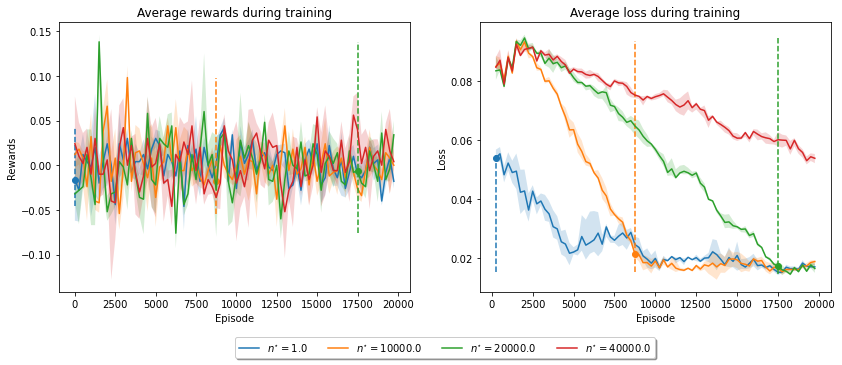

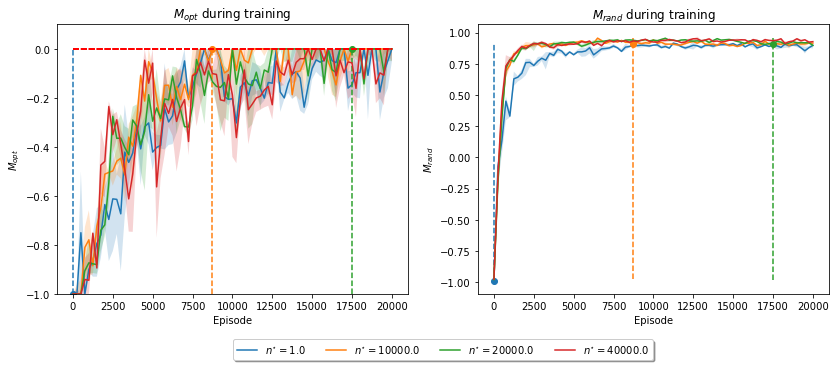

In [31]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_dqn_n_star_self_practice.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_self_list_deep = pickle.load(handle)

plot_n_star = [vec_n_star[i] for i in [0, 5, 7, 9]]
plot_stats(stats_dict_nstar_self_list_deep, plot_n_star, 'n_star_dqn_self', "n^{\star}", save=save_figs, decaying_exploration=True, perc=True)

n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.908
n_star = 100.0 : 	M_opt =  -0.093 	M_rand =  0.867
n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.897
n_star = 5000.0 : 	M_opt =  0.0 	M_rand =  0.912
n_star = 7071.0 : 	M_opt =  0.0 	M_rand =  0.915
n_star = 10000.0 : 	M_opt =  0.0 	M_rand =  0.907
n_star = 14142.0 : 	M_opt =  -0.111 	M_rand =  0.914
n_star = 20000.0 : 	M_opt =  0.0 	M_rand =  0.92
n_star = 28284.0 : 	M_opt =  -0.087 	M_rand =  0.928
n_star = 40000.0 : 	M_opt =  0.0 	M_rand =  0.9430000000000001


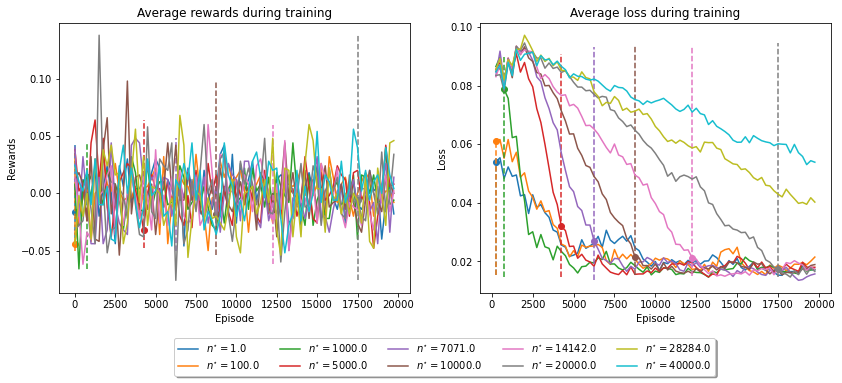

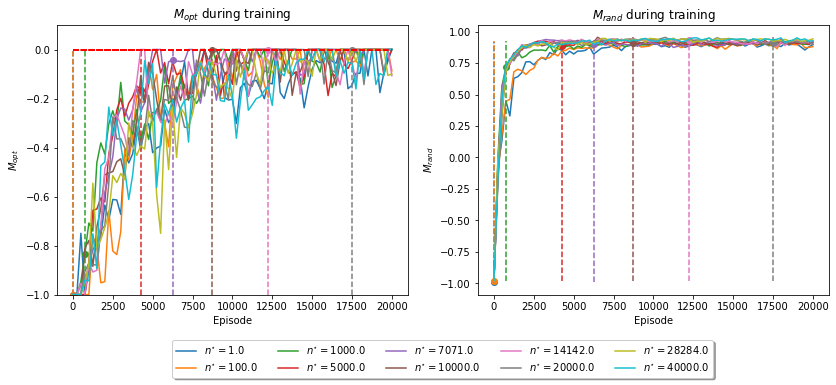

In [32]:
plot_stats(stats_dict_nstar_self_list_deep, vec_n_star, 'n_star', "n^{\star}", save=False, decaying_exploration=True)

### Question 18: Best values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [ ]:
# TODO

### Question 19: Heatmaps of the Q-values in 3 significant states

In [ ]:
# Optimal parameters
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 15000
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)
model, stats = deep_q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, num_episodes=20000, 
                               verbose=True, against_opt=True)

In [ ]:
grids = np.array([[[1., 0., 0.], [-1., 1., 0.], [0., -1., 0.]]])
print(grids[0])
heatmaps_deep_subplots(grids, model, save=save_figs)